# Segmentar clientes para melhorar o desempenho do Marketing

A empresa objeto do case deseja maximizar o lucro na venda de um novo gadget através de uma campanha de marketing. Para melhor selecionar quais clientes serão alvos dessa campanha, ela realizou um piloto com 2240 clientes: (*pelo que entendi*) esses clientes foram alvos de 6 campanhas de marketing, sendo a sexta campanha a selecionada para ser expandida para a base de clientes.

Pensei em algumas ideias de segmentação, baseado no que vi dos dados e no que vi sobre segmentação de clientes ([exemplo](https://www.analyticsvidhya.com/blog/2021/06/how-to-solve-customer-segmentation-problem-with-machine-learning/)):

* Segmentar clientes em relação ao resultado de cada campanha e a partir dessa segmentação buscar identificar características do cliente que possam estar associadas ao sucesso da campanha - essa informação, supondo que cada campanha foi diferente, pode trazer insights sobre que características de uma campanha contribuem para melhor alcançar certo segmento de clientes;

* Segmentar clientes de acordo com o modelo RFM (Recency, Frequency, Monetary). Vi sobre esse modelo em um vídeo no Youtube (não guardei o link...) e ele propõe um modelo de análise de dados de clientes baseado nessas três dimensões, Recency, Frequency e Monetary. A partir dessas dimensões e da posição do cliente nelas podem ser pensados segmentos que podem ser utilizados para orientar a forma com que a empresa irá se relacionar com o cliente. Abaixo segue uma imagem exemplo ([fonte](https://how-many-steps-inc.webflow.io/rfm-segmentation-overview)):

<img src="../imgs/5c09b35cd457987390b70b7c_11 RFM Customer Segments - Retail.png" width="700px"/>

Achei mais interessante e simples a segunda ideia, que irei desenvolver abaixo. Irei me basear nos segmentos apresentados na imagem acima, mas simplificando para 4 segmentos:

(**Frequency+Monetary, Recency**)

* (**baixo, alto**) Pouco potencial: clientes com pouco potencial 
* (**alto, alto**) Reconquistar: ótimos clientes que estão deixando de consumir e devem ser reconquistados
* (**baixo, baixo**) Fidelizar: clientes a estimular que consumam mais frequentemente ou em maior volume
* (**alto, baixo**) Manter: ótimos clientes e fieis, a serem mantidos

Para tanto, irei usar 3 atributos do dataset que representam essas dimensões:

* **Frequency**: *Total_Purchases_Per_Total_Days_Relationship* - calculado como o total de compras nos três canais de venda, divido pela quantidade de dias de relacionamento com a empresa (assumindo que os dados foram coletados em 01/01/2016)
* **Monetary**: *Total_Mnt_Per_Total_Days_Relationship* - calculado como o total gasto com as 5 categorias de produtos nos últimos 2 anos, dividido pela quantidade de dias de relacionamento com a empresa (aqui há um ponto de atenção com a distorção causada por clientes com mais de 2 anos de relacionamento com a empresa)
* **Recency**: *Recency*

Para unir os atributos usados nas dimensões Frequency e Monetary irei aplicar uma média harmônica, visto serem taxas.

A divisão em quadrantes foi feita usando a mediana de cada dimensão.

In [51]:
%run ../scripts/toolbelt.py
%matplotlib inline
from scipy import stats
import numpy as np
from matplotlib.lines import Line2D

In [7]:
df = read_cleaned_data()

In [10]:
df["Frequency+Monetary"] = stats.hmean(df.loc[:, ["Total_Purchases_Per_Total_Days_Relationship", "Total_Mnt_Per_Total_Days_Relationship"]], axis=1)

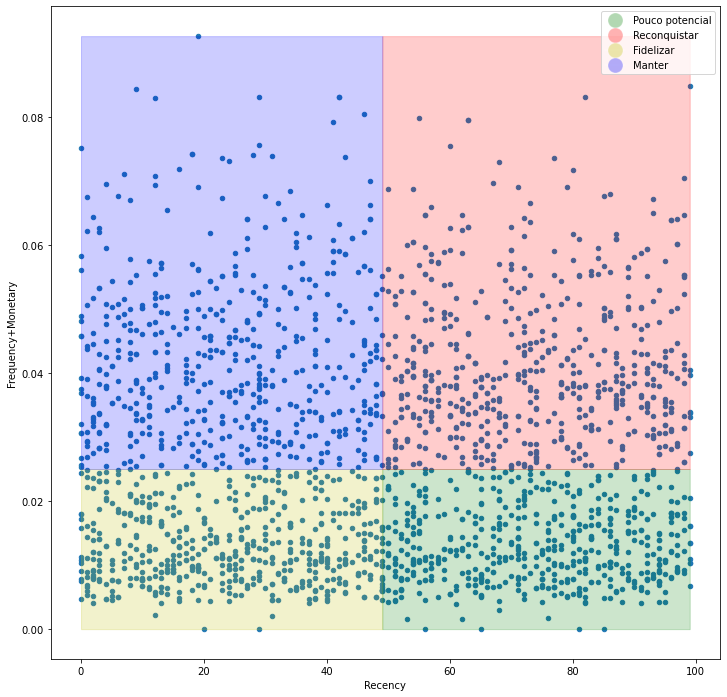

In [48]:
ax = df.plot(kind="scatter", x="Recency", y="Frequency+Monetary", figsize=(12, 12))

min_fm, max_fm = df["Frequency+Monetary"].min(), df["Frequency+Monetary"].max()

min_r, max_r = df["Recency"].min(), df["Recency"].max()

median_fm = df["Frequency+Monetary"].median()
median_r = df["Recency"].median()

l11 = np.arange(min_r, median_r, .001)
l12 = np.arange(median_r, max_r, .001)

ax.fill_between(l11, median_fm, alpha=0.2, color="y")
ax.fill_between(l12, median_fm, alpha=0.2, color="g")
ax.fill_between(l11, median_fm, max_fm, alpha=0.2, color="b")
ax.fill_between(l12, median_fm, max_fm, alpha=0.2, color="r")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Pouco potencial', markerfacecolor='g', markersize=15, alpha=.3),
    Line2D([0], [0], marker='o', color='w', label='Reconquistar', markerfacecolor='r', markersize=15, alpha=.3),
    Line2D([0], [0], marker='o', color='w', label='Fidelizar', markerfacecolor='y', markersize=15, alpha=.3),
    Line2D([0], [0], marker='o', color='w', label='Manter', markerfacecolor='b', markersize=15, alpha=.3)
]
ax.legend(handles=legend_elements, loc='upper right')

## Classificando os clientes nos quadrantes

In [49]:
df["RFM_Quadrant"] = None

baixo_fm = df["Frequency+Monetary"] < median_fm
alto_fm = df["Frequency+Monetary"] >= median_fm
baixo_r = df["Recency"] < median_r
alto_r = df["Recency"] >= median_r

df.loc[baixo_fm & baixo_r, "RFM_Quadrant"] = "Fidelizar"
df.loc[baixo_fm & alto_r, "RFM_Quadrant"] = "Pouco potencial"
df.loc[alto_fm & baixo_r, "RFM_Quadrant"] = "Manter"
df.loc[alto_fm & alto_r, "RFM_Quadrant"] = "Reconquistar"

In [52]:
df.to_csv(RFM_DATA_FILEPATH)